In [1]:
import numpy as np
import ctypes, time, os
from ipywidgets import interact, widgets

# Import visualization stuff
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from scipy.signal import detrend

# Import popeye stuff
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.models_cclab as prfModels

# Import multiprocessing stuff
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

# Load helper functions
from dataloader import *
from fit_utils import *
%load_ext autoreload
%autoreload 2

In [2]:
# Initialize parameters
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 83.5 #63 #83.5 # in cm
params['screenWidth'] = 36.2 #35 #36.2 # in cm
params['scaleFactor'] = 1
params['resampleFactor'] = 1
params['dtype'] = ctypes.c_int16

p = set_paths(params)

# Load stimulus
bar, stim_params = load_stimuli(p)
bar = bar[:, :, 0:201]
# Mirror y axis (this is done because popeye flips the y axis)
bar = np.flip(bar, axis=0)

copy_files(p, params)

# Extract number of TRs
method = 'ss5'
func_data = nib.load(p['pRF_' + method])
f_header = func_data.header
params['tr_length'] = f_header['pixdim'][4]
params['voxel_size'] = [f_header['pixdim'][i] for i in range(1, 4)]
params['nTRs'] = func_data.shape[-1]

# model to fit to
scan_data = func_data.get_fdata()
scan_data = remove_trend(scan_data, method='demean')

# Ground truth model-fit from mrVista
popeye_fit_path = os.path.join(p['pRF_data'], 'JC', 'mrVistaFit', 'RF_' + method + '-fFit.nii.gz')
mrVista_fit = nib.load(popeye_fit_path).get_fdata()

# brainmask_data = nib.load(p['pRF_brainmask']).get_fdata() != 0
# # Resample brainmask if first 2 dimensions are twice the third dimension
# if brainmask_data.shape[0] == 2*brainmask_data.shape[2]:
#     brainmask_data = brainmask_data[::2, ::2, :]


# create stimulus object from popeye
stimulus = VisualStimulus(bar.astype('int16'),
                          params['viewingDistance'],
                          params['screenWidth'],
                          params['scaleFactor'],
                          params['tr_length'],
                          params['dtype'],
)
                        #  'blinear')

Subject folder already exists


In [ ]:
# Crete an animation through time for stimulus.stim_arr whose third axis is time
def animate(time):
    plt.imshow(stimulus.stim_arr[:, :, time], cmap='gray')
    plt.show()

interact(animate, time=widgets.IntSlider(min=0, max=stimulus.stim_arr.shape[-1]-1, step=1, value=0))

In [17]:
# Testing only on visual ROIs
# Load visual ROIs
lh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V1.nii.gz')).get_fdata()
lh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V2d.nii.gz')).get_fdata()
lh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3d.nii.gz')).get_fdata()
lh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3AB.nii.gz')).get_fdata()
rh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V1.nii.gz')).get_fdata()
rh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V2d.nii.gz')).get_fdata()
rh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3d.nii.gz')).get_fdata()
rh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3AB.nii.gz')).get_fdata()
# Combine all ROIs using boolean OR
visual_rois = lh_v1 + lh_v2d + lh_v3d + lh_v3ab + rh_v1 + rh_v2d + rh_v3d + rh_v3ab
visual_rois = visual_rois > 0
visual_rois = lh_v1 + rh_v1 + lh_v2d + rh_v2d #+ lh_v3d + rh_v3d
visual_rois = visual_rois > 0

trueFit_data = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'mrVistaFit/RF_ss5-fFit.nii.gz')).get_fdata()
r2_data = trueFit_data[:, :, :, 1]
r2visual_data = r2_data[visual_rois]
r2sorted = np.sort(r2visual_data.flatten())[::-1]
nvoxs = 20
r2thresh = r2sorted[nvoxs]
visual_rois = r2_data > r2thresh

In [18]:
np.sum(visual_rois)

61

In [29]:
css_model = prfModels.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf, normalizer=utils.percent_change)
css_model.hrf_delay = 0
css_model.mask_size = 5 # standard deviations of the gaussian

# Create scan data just for visual ROIs
scan_data_visual = scan_data.copy()
scan_data_visual[~visual_rois] = 0

[xi, yi, zi] = np.nonzero(visual_rois)
indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]
num_voxels = len(indices)
timeseries_data = scan_data_visual[xi, yi, zi, :]

# set search grids
Ns = 4
x_grid = utils.grid_slice(-12.4, 12.4, 20)
y_grid = utils.grid_slice(-12.4, 12.4, 20)
s_grid = utils.grid_slice(1/css_model.stimulus.ppd0, 10, Ns)
n_grid = utils.grid_slice(0.25, 1, Ns)
grids = (x_grid, y_grid, s_grid, n_grid,)

# Set search bounds
x_bounds = (-15.0, 15.0)
y_bounds = (-15.0, 15.0)
s_bounds = (1/css_model.stimulus.ppd0, 5.25)
n_bounds = (0.2, 1)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, n_bounds, b_bounds, m_bounds)

verbose = 0
auto_fit = 1

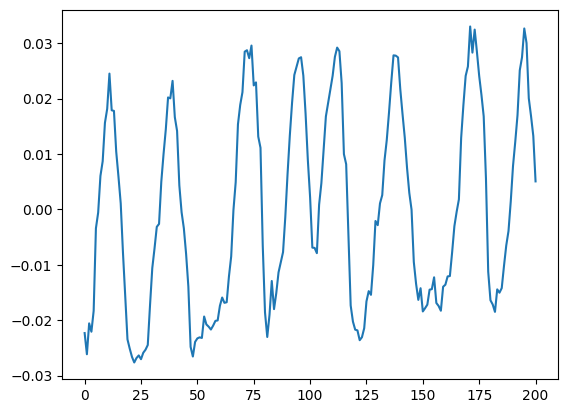

In [24]:
vx_to_plot = 1
plt.figure()
plt.plot(scan_data_visual[xi[vx_to_plot], yi[vx_to_plot], zi[vx_to_plot], :])
plt.show()

In [30]:
# Create a result holder
RF_ss5_gFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 9))
RF_ss5_fFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 9))
vx_indices = np.argwhere(visual_rois)

In [31]:
def process_voxel(ix, iy, iz):
    if visual_rois[ix, iy, iz] == 1:
        th_vx_idx = np.where((vx_indices == (ix, iy, iz)).all(axis=1))[0][0]
        if np.mod(th_vx_idx, 500) == 0:
            run_time = time.time() - start_time
            if run_time < 60:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {round(run_time, 2)} s")
            elif run_time < 3600:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {int(np.floor(run_time/60))} min {round(run_time%60)} s")
            else:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {int(np.floor(run_time/3600))} h {int(np.floor(run_time%3600/60))} min {round(run_time%60)} s")
        voxel_data = scan_data[ix, iy, iz, :]
        fit = prfModels.CompressiveSpatialSummationFit(
            css_model,
            voxel_data,
            grids,
            bounds,
            (ix, iy, iz),
            auto_fit=auto_fit,
            grid_only=False,
            verbose=verbose
        )
        return (ix, iy, iz, fit.theta0, fit.rsquared0, fit.rho0, fit.s0, fit.n0, fit.x0, fit.y0, fit.beta0, fit.baseline0,
                            fit.theta, fit.rsquared, fit.rho, fit.sigma, fit.n, fit.x, fit.y, fit.beta, fit.baseline)
    
    return None

start_time = time.time()

futures = []
with ThreadPoolExecutor() as executor:
    for ix in range(visual_rois.shape[0]):
        for iy in range(visual_rois.shape[1]): 
            for iz in range(visual_rois.shape[2]):
                futures.append(executor.submit(process_voxel, ix, iy, iz))

results = [f.result() for f in futures]

for result in results:
    if result is not None:
        ix, iy, iz, theta0, rsquared0, rho0, sigma0, n0, x0, y0, beta0, baseline0, theta, rsquared, rho, sigma, n, x, y, beta, baseline = result
        # Get the grid fit estimates
        RF_ss5_gFit[ix, iy, iz, 0] = theta0
        RF_ss5_gFit[ix, iy, iz, 1] = rsquared0
        RF_ss5_gFit[ix, iy, iz, 2] = rho0
        RF_ss5_gFit[ix, iy, iz, 3] = sigma0
        RF_ss5_gFit[ix, iy, iz, 4] = n0
        RF_ss5_gFit[ix, iy, iz, 5] = x0
        RF_ss5_gFit[ix, iy, iz, 6] = y0
        RF_ss5_gFit[ix, iy, iz, 7] = beta0
        RF_ss5_gFit[ix, iy, iz, 8] = baseline0

        # Get the full fit estimates
        RF_ss5_fFit[ix, iy, iz, 0] = theta
        RF_ss5_fFit[ix, iy, iz, 1] = rsquared
        RF_ss5_fFit[ix, iy, iz, 2] = rho
        RF_ss5_fFit[ix, iy, iz, 3] = sigma
        RF_ss5_fFit[ix, iy, iz, 4] = n
        RF_ss5_fFit[ix, iy, iz, 5] = x
        RF_ss5_fFit[ix, iy, iz, 6] = y
        RF_ss5_fFit[ix, iy, iz, 7] = beta
        RF_ss5_fFit[ix, iy, iz, 8] = baseline

end_time = time.time()
print()
print(f"Time taken for fitting: {end_time - start_time}")

Finished: 0.0%, time: 8.28 s

Time taken for fitting: 2231.6226949691772


In [12]:
trueFit_data = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'mrVistaFit/RF_ss5-fFit.nii.gz')).get_fdata()

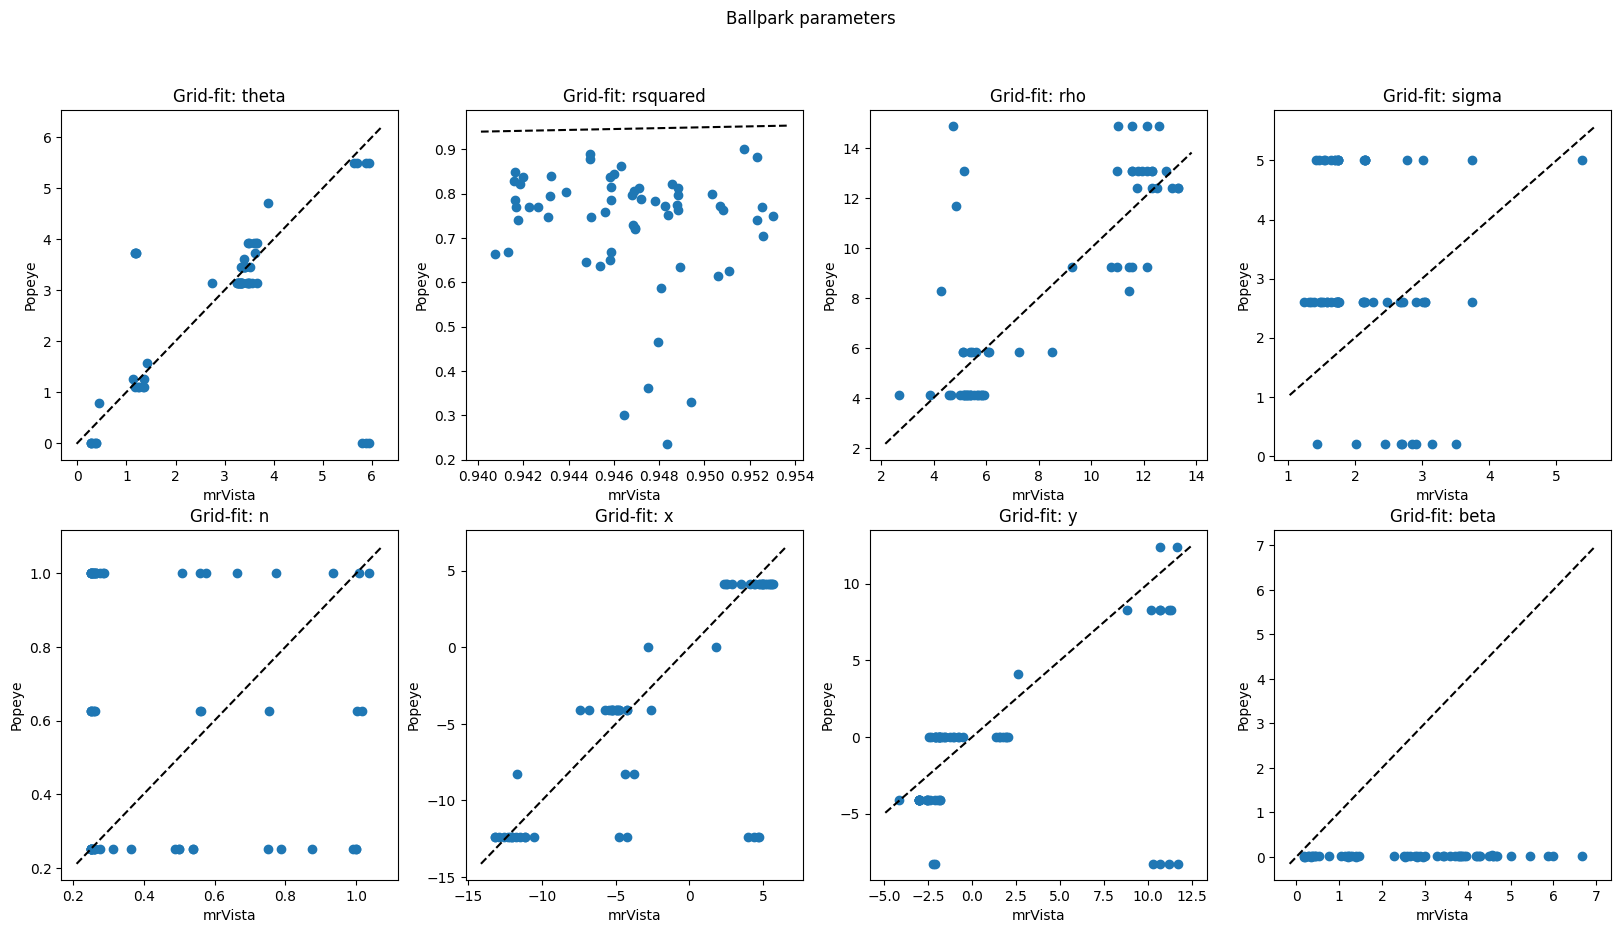

In [27]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax = axs.flatten()[i]
    ax.plot(trueFit_data[visual_rois, i].flatten(), RF_ss5_gFit[visual_rois, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Grid-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
plt.suptitle("Ballpark parameters")
plt.show()

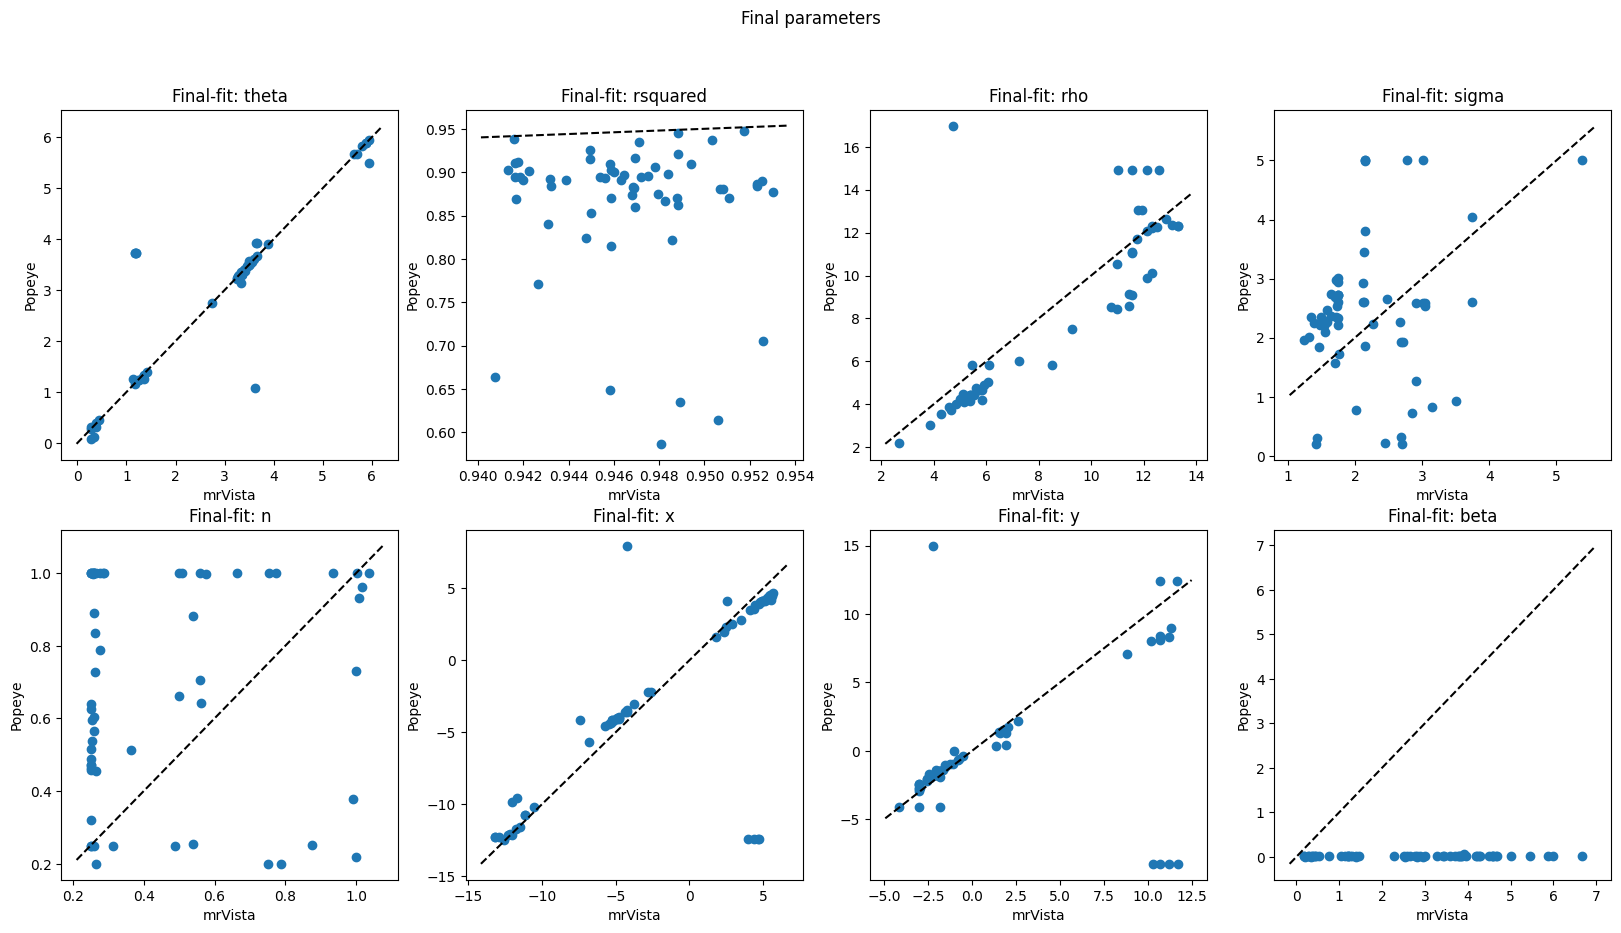

In [28]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax = axs.flatten()[i]
    # this_truth = trueFit_data[visual_rois, i]
    ax.plot(trueFit_data[visual_rois, i].flatten(), RF_ss5_fFit[visual_rois, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Final-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
plt.suptitle("Final parameters")
plt.show()

In [ ]:
visual_rois[0]

In [ ]:
from popeye.spinach import generate_og_receptive_field, generate_rf_timeseries, generate_mp_timeseries
from scipy.signal import fftconvolve
from scipy.stats import linregress
vx = 5
Ff = RF_ss5_fFit[xi[vx], yi[vx], zi[vx], :]
rf = generate_og_receptive_field(Ff[5], Ff[6], Ff[3], stimulus.deg_x, stimulus.deg_y)
rf /=  ((2 * np.pi * Ff[3]**2) * 1/np.diff(stimulus.deg_x0[0,0:2])**2)
plt.figure()
plt.imshow(rf)
plt.colorbar()
plt.show()

In [ ]:
def distance_mask_coarse(x, y, sigma):
    dist = (stimulus.deg_x0 - x) ** 2 + (stimulus.deg_y0 - y) ** 2
    mask = np.empty_like(dist, dtype='uint8')
    mask[dist < 5*sigma**2] = 1
    return mask
mask = distance_mask_coarse(Ff[5], Ff[6], Ff[3])
resp = generate_rf_timeseries(stimulus.stim_arr0, rf, mask)
resp = resp ** Ff[4]
# data = resp * 100 + 100
data = scan_data_visual[xi[vx], yi[vx], zi[vx], :]
# data = data * np.mean(data) + np.mean(data)

# data = utils.percent_change(data)
# data = (data - np.mean(data)) / np.mean(data)
# data = utils.percent_change(data)
model = fftconvolve(resp, utils.double_gamma_hrf(0, 1.3))[0:len(resp)]

model = (model - np.mean(model)) / np.mean(model)
# model = utils.percent_change(model, ax=-1)
# model = ( (model / np.mean(model)) - 1 ) * 100

p = linregress(model, data)
print(p[0], p[1])
# model = (model - model.mean())/ model.mean()
# model = (model / model.mean() - 1) * 100
f, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].plot(resp)
axs[0,1].plot(data)
axs[1,0].plot(model)
axs[1,1].plot(p[0] * model + p[1])

plt.show()

In [ ]:
# Plot histograms for each parameter in RF_sst_fFit
f, axs = plt.subplots(3, 3, figsize=(20, 10))
for i in range(9):
    ax = axs.flatten()[i]
    ax.hist(RF_ss5_fFit[visual_rois, i].flatten(), bins=50)
    ax.set_title(f"Final-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta', 'baseline'][i]}")
plt.suptitle("Final parameters")
plt.show()

In [ ]:
# Save the results
anat_data = nib.load(p['pRF_anat']) #.get_fdata()
# popeye_fFit = nib.Nifti1Image(RF_ss5_fFit, affine=anat_data.affine, header=anat_data.header)
popeye_fFit = nib.nifti1.Nifti1Image(RF_ss5_fFit, affine=func_data.affine, header=func_data.header)
# popeye_gFit = nib.Nifti1Image(RF_ss5_gFit, affine=anat_data.affine, header=anat_data.header)
popeye_gFit = nib.nifti1.Nifti1Image(RF_ss5_gFit, affine=func_data.affine, header=func_data.header)
if not os.path.exists(os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit')):
    os.makedirs(os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit'))
nib.save(popeye_fFit, os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit', 'RF_ss5_fFit_popeye.nii.gz'))
nib.save(popeye_gFit, os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit', 'RF_ss5_gFit_popeye.nii.gz'))